## Setup

In [9]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd

from harp_resources import process, utils
from sleap import load_and_process as lp

In [50]:
#data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/2024-08-12T16-51-16_B3M3')
#photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/photometry/B3M3_MMclosed&Regular_day1/2024_08_12-18_57_17')


In [51]:
rootdir = '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824' #Enter root path
data_paths = []
photometry_paths= []
for dirpath, subdirs, files in os.walk(rootdir):
    for x in files:
        if 'ExperimentEvents' in x:
            data_paths.append(dirpath[:-17])
        if 'Fluorescence.csv' in x:
            photometry_paths.append(dirpath)




In [52]:
'2024-08-08T08-22-12_B2M5'[20:]

'B2M5'

In [53]:
def run_extraction_makeh5(data_path, photometry_path, make_h5 = False):
    print(f'\n Running extraction for {data_path.split('/')[-1][20:]} for session {data_path.split('/')[-2]}')
    data_path = Path(data_path)
    photometry_path = Path(photometry_path)
    SessionSettings = utils.read_SessionSettings(data_path, print_contents=True)
    conversions = process.calculate_conversions_second_approach(data_path, photometry_path, verbose=False)
    streams = utils.load_registers(data_path)

    Photometry = utils.read_fluorescence(photometry_path)
    Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])
    
    OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
    OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)
    ExperimentEvents = utils.read_ExperimentEvents(data_path) 
    
    photodiode_series = pd.Series(OnixAnalogData[:,0], index=conversions['onix_to_harp_timestamp'](OnixAnalogClock))

    print('Adding Photometry, Eye Movements and Photodiode to the streams')
    streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['CH1-410', 'CH1-470', 'CH1-560'], index_column_name='HARP Timestamps')
    streams = process.add_stream(streams, 'ONIX', photodiode_series, 'Photodiode')
    
    
    _ = process.get_timepoint_info(streams, print_all=True)
    resampled_streams = process.pad_and_resample(streams, resampling_period='1 ms', method='linear')
    _ = process.get_timepoint_info(resampled_streams, print_all=True)

    print('Applying linear and angular conversion to Optical tracking sensor streams (cm / sec and degrees / sec)')
    resampled_streams['H1']['OpticalTrackingRead0X(46)'] = process.running_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0X(46)']*100)
    resampled_streams['H1']['OpticalTrackingRead0Y(46)'] = process.rotation_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0Y(46)'])

    print('Streams are extracted and can be used or made to h5')
    if make_h5:
        process.save_streams_as_h5(data_path, resampled_streams, streams_to_save_pattern)


In [54]:
data_path
for path in photometry_paths:
    if data_path[len(data_path)-4:] in path:
        photometry_path = Path(path)

data_path = Path(data_path)

print(data_path, '\n', photometry_path)

TypeError: object of type 'PosixPath' has no len()

In [ ]:
for data, photometry in zip(data_paths, photometry_paths):
    if data[len(data)-4:] in photometry:
        print(data, photometry)
        run_extraction_makeh5(data, photometry)

In [38]:
type(photometry_paths[1])

str

## Loading and Synchronisation 

In [55]:
conversions = process.calculate_conversions_second_approach(data_path, photometry_path, verbose=False)
# After hardware ONIX clock implementation - this will have to be adapted
# Only photometry will need to be converted

OnixAnalogClock loaded in 6.44 seconds.


/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:75: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()



Shape of OnixAnalogClock == [218759300] shape of OnixAnalogFrameCount == [218764700].
Cutting 5400 values from the beginning of OnixAnalogFrameCount. Data considered to be MISSING.

OnixDigital has 707 events and Events.csv has 698 events. Cutting to the minimum 698 events from the beggining, aligning by the end.

Calculation of conversions finished in 81.39 seconds.


/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


In [56]:
streams = utils.load_registers(data_path)

Photometry = utils.read_fluorescence(photometry_path)
Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])

OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)
ExperimentEvents = utils.read_ExperimentEvents(data_path) 

photodiode_series = pd.Series(OnixAnalogData[:,0], index=conversions['onix_to_harp_timestamp'](OnixAnalogClock))

Dataset 2024-08-08T08-22-12_B2M5 contains following registers:
H1: [32, 33, 46]
H2: [39, 42]
Registers loaded in 3.33 seconds.
OnixAnalogClock loaded in 5.88 seconds.
OnixAnalogData loaded in 162.24 seconds.


/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


In [57]:
# Adding Photometry, Eye Movements and Photodiode to the streams
streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['CH1-410', 'CH1-470', 'CH1-560'], index_column_name='HARP Timestamps')
streams = process.add_stream(streams, 'ONIX', photodiode_series, 'Photodiode')

In [64]:
_ = process.get_timepoint_info(streams, print_all=True)
resampled_streams = process.pad_and_resample(streams, resampling_period='1 ms', method='linear')
_ = process.get_timepoint_info(resampled_streams, print_all=True)

Global first timestamp: 1904-01-09 19:54:29.679488
Global last timestamp: 1904-01-09 20:31:03.269787765
Global length: 0 days 00:36:33.590299765

H1
Cam0Event(32): 
	first  1904-01-09 19:54:29.680640 
	last   1904-01-09 20:31:00.971808 
	length 0 days 00:36:31.291168 
	mean difference between timestamps 0 days 00:00:00.016666092
Cam1Event(33): 
	first  1904-01-09 19:54:29.680640 
	last   1904-01-09 20:31:00.971808 
	length 0 days 00:36:31.291168 
	mean difference between timestamps 0 days 00:00:00.016666092
OpticalTrackingRead0X(46): 
	first  1904-01-09 19:54:29.680256 
	last   1904-01-09 20:31:00.970240 
	length 0 days 00:36:31.289984 
	mean difference between timestamps 0 days 00:00:00.009999999
OpticalTrackingRead0Y(46): 
	first  1904-01-09 19:54:29.680256 
	last   1904-01-09 20:31:00.970240 
	length 0 days 00:36:31.289984 
	mean difference between timestamps 0 days 00:00:00.009999999
OpticalTrackingRead0Brightness(46): 
	first  1904-01-09 19:54:29.680256 
	last   1904-01-09 20:31:0

In [65]:
# Applying linear and angular conversion to Optical tracking sensor streams
# OpticalTrackingRead0X(46) converted to centimeters per second
# OpticalTrackingRead0Y(46) covnerted to degrees per second
resampled_streams['H1']['OpticalTrackingRead0X(46)'] = process.running_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0X(46)']*100)
resampled_streams['H1']['OpticalTrackingRead0Y(46)'] = process.rotation_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0Y(46)'])

In [67]:
print(type(resampled_streams['Photometry']['CH1-470']))
resampled_streams['Photometry']['CH1-470']

<class 'pandas.core.series.Series'>


1904-01-09 19:54:29.679     0.000000
1904-01-09 19:54:29.680     0.001054
1904-01-09 19:54:29.681     0.002108
1904-01-09 19:54:29.682     0.003161
1904-01-09 19:54:29.683     0.004215
                             ...    
1904-01-09 20:31:03.265    44.381788
1904-01-09 20:31:03.266    44.376091
1904-01-09 20:31:03.267    44.370394
1904-01-09 20:31:03.268    44.364697
1904-01-09 20:31:03.269    44.359000
Freq: ms, Length: 2193591, dtype: float64

In [19]:
streams_to_save_pattern = {'H1': ['OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)'], 'H2': ['Encoder(38)'], 'Photometry': ['CH1-410', 'CH1-470', 'CH1-560'], 'ONIX': ['Photodiode']}
streams_to_save_pattern


{'H1': ['OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)'],
 'H2': ['Encoder(38)'],
 'Photometry': ['CH1-410', 'CH1-470', 'CH1-560'],
 'ONIX': ['Photodiode']}

## Making and saving test streams

In [18]:
import numpy as np
import pandas as pd
import random

# Define the time range
start_time = pd.Timestamp('1904-01-09 19:54:29.679')
end_time = pd.Timestamp('1904-01-09 20:31:03.269')
freq = '0.1ms'  # 0.1 milliseconds
timestamps = pd.date_range(start=start_time, end=end_time, freq=freq)
session = 2

if session == 1:
    # Create sine wave 1 (1 Hz frequency)
    sine_wave1 = pd.Series(
        np.sin(3 * np.pi * 1.5 * (timestamps - timestamps[0]).total_seconds() / 60),
        index=timestamps
    )
    
    # Create sine wave 2 (0.5 Hz frequency)
    sine_wave2 = pd.Series(
        np.sin(1 * np.pi * 0.35 * (timestamps - timestamps[0]).total_seconds() / 60),
        index=timestamps
    )
    
    # Create square wave
    square_wave = pd.Series(
        (np.sign(np.sin(2 * np.pi * 0.5 * (timestamps - timestamps[0]).total_seconds() / 60)) > 0).astype(float),
        index=timestamps
    )
    
    # Create boolean stream
    boolean_values = np.random.choice(
        [True, False], 
        size=len(timestamps), 
        p=[0.98, 1-0.98]  # Probability of True and False
    )


if session == 2:
    # Create sine wave 1 (1 Hz frequency)
    sine_wave1 = pd.Series(
        np.sin(2 * np.pi * 1 * (timestamps - timestamps[0]).total_seconds() / 60),
        index=timestamps
    )
    
    # Create sine wave 2 (0.5 Hz frequency)
    sine_wave2 = pd.Series(
        np.sin(3 * np.pi * 0.5 * (timestamps - timestamps[0]).total_seconds() / 60),
        index=timestamps
    )
    
    # Create square wave
    square_wave = pd.Series(
        (np.sign(np.sin(2 * np.pi * 1 * (timestamps - timestamps[0]).total_seconds() / 60)) > 0).astype(float),
        index=timestamps
    )
    
    # Create boolean stream
    boolean_values = np.random.choice(
        [True, False], 
        size=len(timestamps), 
        p=[0.96, 1-0.96]  # Probability of True and False
    )

# Create the boolean stream as a Series
boolean_stream = pd.Series(boolean_values, index=timestamps)
# Sparse event stream
event_stream = pd.Series(index=timestamps, dtype="object")
event_indices = sorted(random.sample(range(len(timestamps)), 20))  # 20 random events
event_values = ["No_halt"] * 15 + [
    "LinearPlaybackMismatch block started",
    "LinearClosedloopMismatch block started",
    "Block timer elapsed",
]
random.shuffle(event_values)
for idx, val in zip(event_indices, event_values):
    event_stream.iloc[idx] = val

# Remove NaNs from the event stream to only keep event timepoints
event_stream = event_stream.dropna()

# Print the series to confirm their format
print("Sine Wave 1:\n", sine_wave1)
print("\nSine Wave 2:\n", sine_wave2)
print("\nSquare Wave:\n", square_wave)
print("\nBoolean Stream:\n", boolean_stream)
print("\nEvent Stream:\n", event_stream)





Sine Wave 1:
 1904-01-09 19:54:29.679000    0.000000
1904-01-09 19:54:29.679100    0.000010
1904-01-09 19:54:29.679200    0.000021
1904-01-09 19:54:29.679300    0.000031
1904-01-09 19:54:29.679400    0.000042
                                ...   
1904-01-09 20:31:03.268600   -0.367112
1904-01-09 20:31:03.268700   -0.367121
1904-01-09 20:31:03.268800   -0.367131
1904-01-09 20:31:03.268900   -0.367141
1904-01-09 20:31:03.269000   -0.367151
Freq: 100us, Length: 21935901, dtype: float64

Sine Wave 2:
 1904-01-09 19:54:29.679000    0.000000
1904-01-09 19:54:29.679100    0.000008
1904-01-09 19:54:29.679200    0.000016
1904-01-09 19:54:29.679300    0.000024
1904-01-09 19:54:29.679400    0.000031
                                ...   
1904-01-09 20:31:03.268600    0.482469
1904-01-09 20:31:03.268700    0.482462
1904-01-09 20:31:03.268800    0.482456
1904-01-09 20:31:03.268900    0.482449
1904-01-09 20:31:03.269000    0.482442
Freq: 100us, Length: 21935901, dtype: float64

Square Wave:
 1904-0

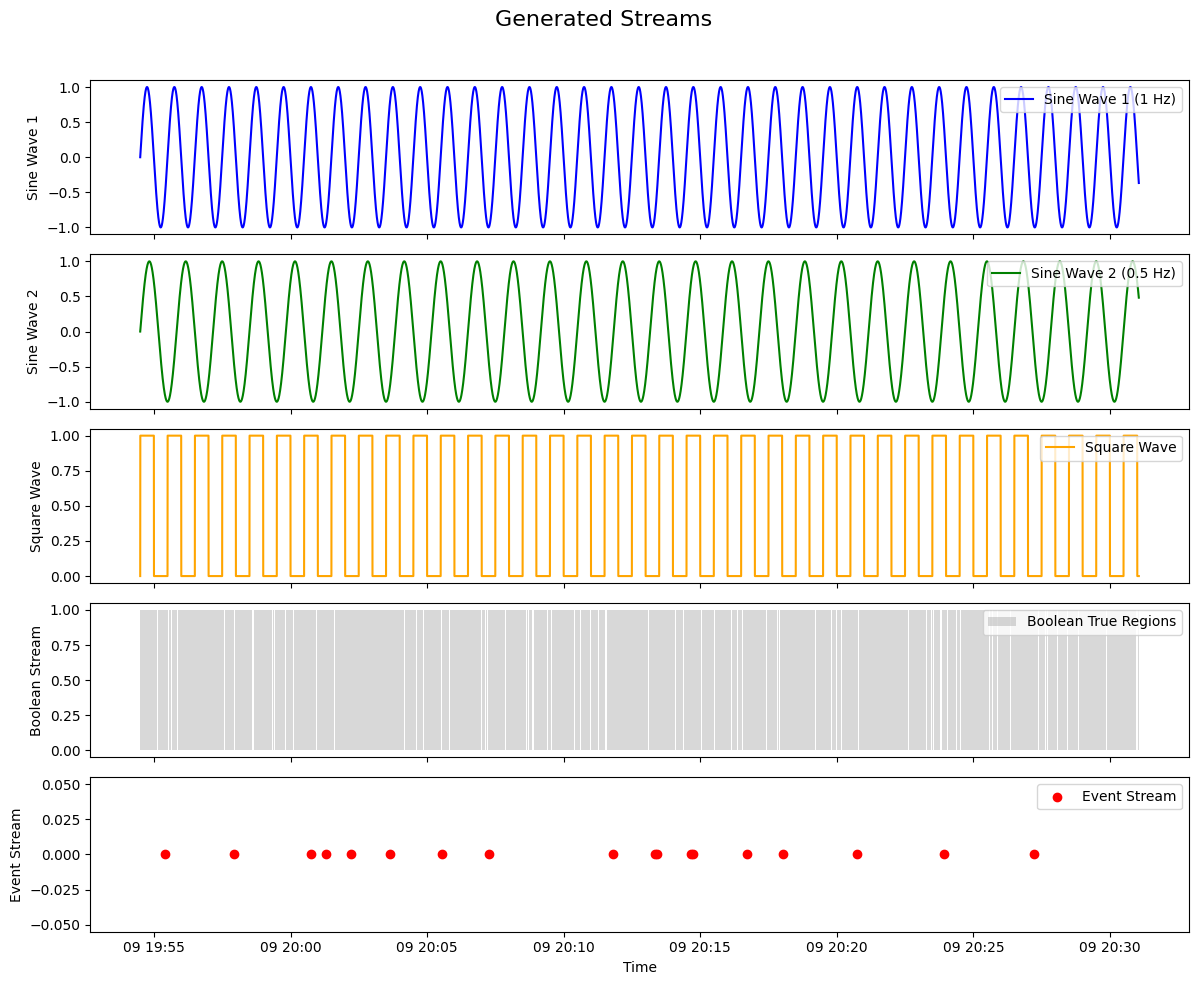

In [19]:
# Create a figure with subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
fig.suptitle("Generated Streams", fontsize=16)

# Plot sine_wave1
axes[0].plot(sine_wave1.index, sine_wave1.values, label="Sine Wave 1 (1 Hz)", color="blue")
axes[0].set_ylabel("Sine Wave 1")
axes[0].legend(loc="upper right")

# Plot sine_wave2
axes[1].plot(sine_wave2.index, sine_wave2.values, label="Sine Wave 2 (0.5 Hz)", color="green")
axes[1].set_ylabel("Sine Wave 2")
axes[1].legend(loc="upper right")

# Plot square_wave
axes[2].plot(square_wave.index, square_wave.values, label="Square Wave", color="orange")
axes[2].set_ylabel("Square Wave")
axes[2].legend(loc="upper right")

# Plot boolean_stream as shaded regions
axes[3].fill_between(boolean_stream.index, 0, 1, where=boolean_stream.values, 
                     facecolor="gray", alpha=0.3, label="Boolean True Regions")
axes[3].set_ylabel("Boolean Stream")
axes[3].legend(loc="upper right")

# Plot event_stream
axes[4].scatter(event_stream.index, [0] * len(event_stream), color="red", label="Event Stream")
axes[4].set_ylabel("Event Stream")
axes[4].legend(loc="upper right")

# Common x-label
axes[-1].set_xlabel("Time")

# Tidy layout

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()


In [20]:

# Define the file paths
if session == 1:
    data_path = Path('/Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_070824/Test_streams_B0M0')
    output_folder = data_path / "ExperimentEvents"
    output_csv_path = output_folder / 'ExperimentEvents_1904-01-02T22-00-00.csv'
if session == 2:
    data_path = Path('/Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0')
    output_folder = data_path / "ExperimentEvents"
    output_csv_path = output_folder / 'ExperimentEvents_1904-01-03T08-00-00.csv'

output_folder.mkdir(parents=True, exist_ok=True)  # Ensure the folder exists


# Convert timestamps to seconds using the provided function
time_in_seconds = process.convert_datetime_to_seconds(event_stream.index)

# Create the DataFrame for saving
event_stream_df = pd.DataFrame({
    "Seconds": time_in_seconds,
    "Value": event_stream.values
})

# Save to CSV
event_stream_df.to_csv(output_csv_path, index=False)

print(f"Event stream saved to {output_csv_path}")


Event stream saved to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0/ExperimentEvents/ExperimentEvents_1904-01-03T08-00-00.csv


In [21]:
percent_true = (len(boolean_stream==True)*100)/len(boolean_stream)


# Count the total number of rows
total_count = boolean_stream.count()

# Count the number of True and False values
true_count = boolean_stream.sum()  # Sums True values (True = 1, False = 0)
false_count = total_count - true_count

# Calculate percentages
true_percentage = (true_count / total_count) * 100
false_percentage = (false_count / total_count) * 100

# Print results
print(f"Percentage of True values: {true_percentage:.2f}%")
print(f"Percentage of False values: {false_percentage:.2f}%")

Percentage of True values: 96.00%
Percentage of False values: 4.00%


In [22]:
data = {'H1': {'OpticalTrackingRead0X(46)': sine_wave1, 'OpticalTrackingRead0Y(46)': square_wave},
        'H2':{}, 
        'Photometry': {'CH1-470': sine_wave2},
        'ONIX': {'Photodiode': boolean_stream}}


streams_to_save_pattern = {'H1': ['OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)'], 
                           'H2': ['Encoder(38)'], 'Photometry': ['CH1-410', 'CH1-470', 'CH1-560'], 'ONIX': ['Photodiode']}

In [23]:
process.save_streams_as_h5(data_path, data, streams_to_save_pattern)

Encoder(38) was included in "streams_to_save_pattern", but cannot be found inside of H2 source of resampled streams.
CH1-410 was included in "streams_to_save_pattern", but cannot be found inside of Photometry source of resampled streams.
CH1-560 was included in "streams_to_save_pattern", but cannot be found inside of Photometry source of resampled streams.
Data saved as H5 file in 3.45 seconds to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0/resampled_streams_Test_streams_B0M0.h5.


In [24]:

# Flatten the dictionary into a DataFrame
columns = []
data_frames = []

for subsystem, streams in data.items():
    for stream_name, series in streams.items():
        # Create column names as "Subsystem: Stream Name"
        column_name = stream_name
        columns.append(column_name)
        print(column_name)
        data_frames.append(series)

OpticalTrackingRead0X(46)
OpticalTrackingRead0Y(46)
CH1-470
Photodiode


In [25]:

combined_df = pd.concat(data_frames, axis=1)
combined_df.columns = columns

# Add the Seconds column
combined_df['Seconds'] = process.convert_datetime_to_seconds(combined_df.index)


# Save to CSV
output_path = f"Original_Fake_data_session{session}.csv"
combined_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")


Data saved to Original_Fake_data_session2.csv
